# Who gets access to the XXX lounge?

Let us predict who is earning more than 50.000 dollar.
Those people will be eligible to stay at our XXX lounge.

In [2]:
import numpy as np
import pandas as pd
from shap.datasets import adult  # shap is only used as dataset utility
import matplotlib.pyplot as plt


From shap library we get the adult census dataset
It consists of a set of variables that can explain how much someone is expected to earn.
It is commonly used for classifying who will earn above the treshold of 50.000 dollars and who below.
The dataset is unbalanced in the sense that there is more cases below 50.000 dollar than above.

The explanatory variables consist of a set of personal details such as age, education level, but contains also sensitive attributes such as sex and race. We will focus us on the role of the sensitive attribute sex.

In [3]:
X, y_true = adult()
X.columns = [col.lower() for col in X.columns]
X.head()

,age,workclass,education-num,marital status,occupation,relationship,race,sex,capital gain,capital loss,hours per week,country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


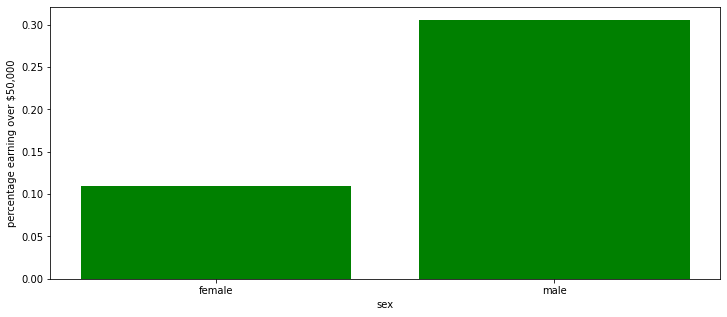

In [4]:
from fairtalk.plots import plot_perc_true_sex

y_true = y_true * 1 
sex = X['sex'].apply(lambda sex: "female" if sex == 0 else "male")

plot_perc_true_sex(y_true, sex)

### Fit an unaware model

We fit a model in which we do not include the sensitive attribute sex.

Right now, we do not care about a proper train and test split, since we only want to indicate the effects of a sensitive attribute and how to mitigate that.


In [5]:
from sklearn.linear_model import LogisticRegression
numeric_columns = ['age', 'capital gain', 'education-num', 'capital loss', 'hours per week']

classifier = LogisticRegression()
classifier.fit(X[numeric_columns], y_true)

y_pred = classifier.predict(X[numeric_columns])
y_prob = classifier.predict_proba(X[numeric_columns])

## Evaluate the fit

Fairlearn has helper functions that make it easy to evaluate (Scikit-learn) metrics by group

In [6]:
from fairlearn.metrics import group_summary
from sklearn.metrics import accuracy_score
group_summary(accuracy_score, y_true, y_pred, sensitive_features=sex)


{'overall': 0.8144713000214981,
 'by_group': {'female': 0.8914678302850246, 'male': 0.7764111977971546}}

And (of course) contains fairness metrics as well

In [7]:
from fairlearn.metrics import selection_rate, ratio_from_summary
selection_rate_summary = group_summary(selection_rate, y_true, y_pred, sensitive_features=sex)
selection_rate_summary

{'overall': 0.13433248364607966,
 'by_group': {'female': 0.07817287159966577, 'male': 0.16209270307480494}}

We notice that we select one group (male) twice as much as the other group (female)

In [8]:
ratio_from_summary(selection_rate_summary)
# Thus one group is twice as much selected as the other

0.4822726138609052

But we notice that the ratio in true positives or false positives between both groups is not that bad.
Thus if we consider other attributes our prediction is not that unfair

In [9]:
from fairlearn.metrics import equalized_odds_ratio
equalized_odds_ratio(y_true, y_pred, sensitive_features=sex)


0.7532645363673709

<b> Accuracy (TP + TN)/ All </b>: The model is better at assesing most appropriate category of women

<b> Balanced accuracy </b>: If the smallest category (positive) gets more weight, weighed accuracy approx the same

<b> Precision TP/ (TP + FP) </b>: More women (+/- 50%) vs men (+/- 25%) are wrongly chosen for the True category

<b> Recall TP/ (TP + FN) </b>: More women are forgot

<b> Selection rate (TP + FP)/ (P + N)  </b>: Men are twice as likely to be selected

In [10]:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features=sex,
                   sensitive_feature_names=['sex'],
                   y_true=y_true,
                   y_pred={"initial model": y_pred})

FairlearnWidget(value={'true_y': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1…

## Make can we get an equal selection to our XXX lounge?

### Mitigate disparity using postprocessing

In [20]:
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError


class LogisticRegressionTransformer(BaseEstimator, ClassifierMixin):
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator

    def fit(self, X, y):
        try:
            check_is_fitted(self.logistic_regression_estimator)
            self.logistic_regression_estimator_ = self.logistic_regression_estimator
        except NotFittedError:
            self.logistic_regression_estimator_ = clone(
                self.logistic_regression_estimator
            ).fit(X, y)
        return self
    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator_.predict_proba(X)[:, 1]
        return scores


estimator_wrapper = LogisticRegressionTransformer(classifier).fit(X[numeric_columns], y_true)

postprocessed_predictor_DP = ThresholdOptimizer(
    estimator=estimator_wrapper, constraints="demographic_parity", prefit=True
)

postprocessed_predictor_DP.fit(
    X[numeric_columns], y_true, sensitive_features=sex
)

fairness_aware_predictions_DP_train = postprocessed_predictor_DP.predict(
    X[numeric_columns], sensitive_features=sex
)

More or less same difference in accuracy, but accuracy for both groups decreased. 

We almost entirely removed difference in prediction

The recall of women improved 36 - 45%.

In [23]:
FairlearnDashboard(sensitive_features=sex,
                   sensitive_feature_names=['sex'],
                   y_true=y_true,
                   y_pred={
                       "initial model": y_pred, 
                       "mitigated_model": fairness_aware_predictions_DP_train
                          }
                  )


FairlearnWidget(value={'true_y': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1…

## Steps of theshold optimizer postprocessing

We compute the ROC charts per group

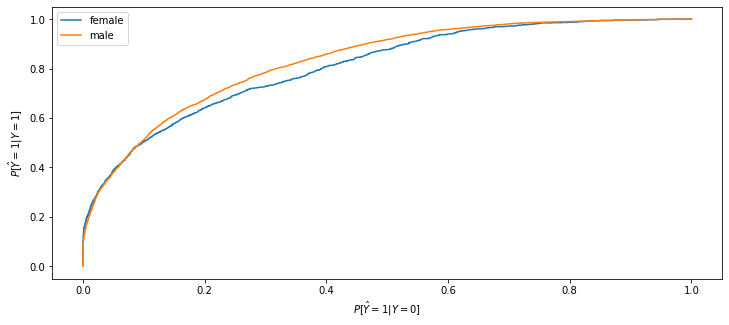

In [13]:
from fairlearn.postprocessing._threshold_optimizer import _reformat_and_group_data
from fairtalk.plots import get_roc_points, plot_roc, plot_convex_hull_interpolation, plot_overall_tradeoff
from fairtalk.plots import plot_creation_convex_hull

data_grouped_by_sensitive_feature = _reformat_and_group_data(sex, y_true, y_prob[:,1])
roc_points = get_roc_points(data_grouped_by_sensitive_feature)
plt1 = plot_roc(data_grouped_by_sensitive_feature, roc_points)


For a lower threshold (operation) we will have more false positives (x) and true positives (y)

In [14]:
(
    roc_points
    .get('male')
    .rename(columns={"x": "False positives", "y": "True positives"})
    .head(n=5)
)

,False positives,True positives,operation
0,0.0,0.000000,[>inf]
1,0.0,0.000150,[>0.999999999999998]
2,0.0,0.000300,[>0.9999999999999977]
3,0.0,0.000450,[>0.9999999999999974]
4,0.0,0.000751,[>0.9999999999999972]


Based on the classifications (true and false positives/ negatives), we can calculate the the selection rate and error (1 - accuracy) for each group.


Then, we can determine the convex Hull

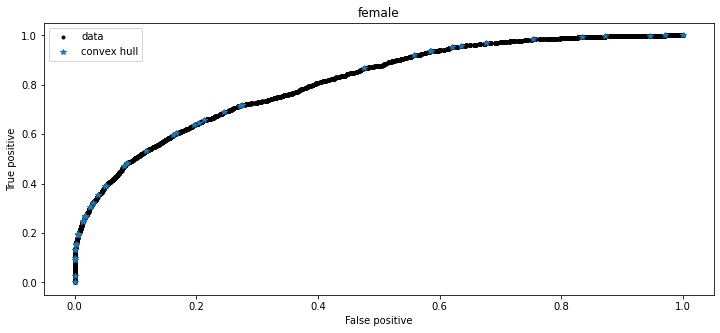

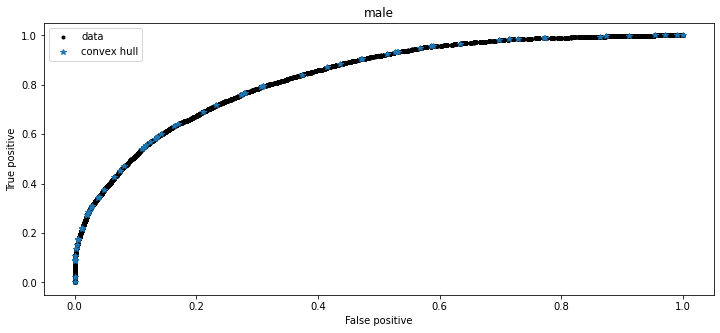

In [15]:
plot_creation_convex_hull(sex, y_true, y_prob[:,1])

Subsequently, we interpolate the convex hull with a grid a of m selection rates.

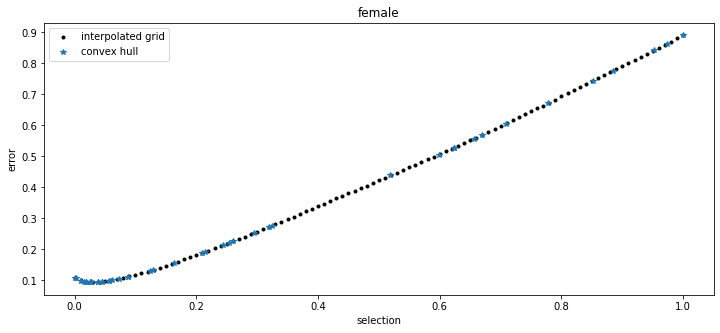

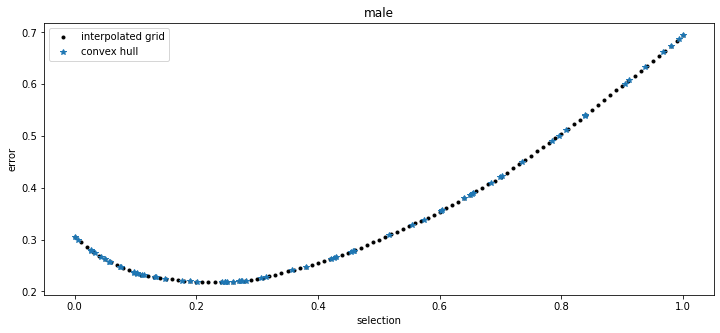

In [16]:
plot_convex_hull_interpolation(sex, y_true, y_prob[:,1])

This gives us a dictionary with which operations/ thresholds we can achieve a certain selection rate/ error for each group.

#### Trade off plot

We pick a selection rate for which the weighted sum of errors is minimal. Thus
different groups will have different thresholds 

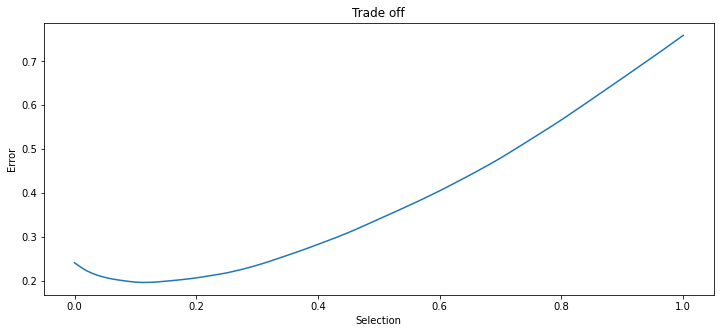

In [17]:
plot_overall_tradeoff(sex, y_true, y_prob[:,1])

In order to obtain same selection rate for all groups, 
the base predictions are reweighted based on the threshold neighbours of the selection rate.

In [18]:
for (
    group,
    interpolation,
) in postprocessed_predictor_DP._post_processed_predictor_by_sensitive_feature.items():
    print("{}:".format(group))
    print("\n ".join(interpolation.__repr__().split(",")))
    print("-----------------------------------")

female:
[p_ignore: 0
  prediction_constant: 0
  p0: 0.32366581632653063
  operation0: [>0.47131790734764345]
  p1: 0.6763341836734693
  operation1: [>0.39114198646527204]]
-----------------------------------
male:
[p_ignore: 0
  prediction_constant: 0
  p0: 0.22661538461538303
  operation0: [>0.6117904984321825]
  p1: 0.773384615384617
  operation1: [>0.603092288604215]]
-----------------------------------
